In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import os
sns.set()

In [62]:
    model_path = '../Modelo/MiBiciTuBici'
    model_output_path = f'{model_path}/model-output'
    processed_output_path = f'{model_path}/processed-model-output/'
    experiment_1_path = f'{model_output_path}/experiment-1'
    experiment_2_path = f'{model_output_path}/experiment-2'

    # --> Sanity checks
    if not os.path.exists(model_output_path) or len(os.listdir(model_output_path)) == 0:
        raise Exception('No model output is available. Run the AnyLogic experiment and try again.')

    if not os.path.exists(experiment_1_path) or len(os.listdir(experiment_1_path)) == 0:
        raise Exception('No model output is available for experiment 1. Run the AnyLogic experiment and try again.')
    if not os.path.exists(experiment_2_path) or len(os.listdir(experiment_2_path)) == 0:
        raise Exception('No model output is available for experiment 2. Run the AnyLogic experiment and try again.')

    if not os.path.exists(processed_output_path):
        os.mkdir(processed_output_path)

    experiment_1_files = os.listdir(experiment_1_path)
    experiment_2_files = os.listdir(experiment_2_path)

    if len(experiment_1_files) != len(experiment_2_files):
        raise Exception('The amount of files for experiment 1 do not match with the amount for experiment 2. Aborting.')

    for file in experiment_1_files:
        if not file.startswith('output') and not file.endswith('.json'):
            raise Exception(f'File {file} is not recognized. Aborting.')

    for file in experiment_2_files:
        if not file.startswith('output') and not file.endswith('.json'):
            raise Exception(f'File {file} is not recognized. Aborting.')

    print(f'-> {len(experiment_1_files)} output files will be processed for each experiment.')
    # -----------------------

    def mean_confidence_interval(data, confidence=0.90):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h

    n_replications = len(experiment_1_files)

    statistics = (
        'totalUsers',
        'co2Avoided',
        'totalKm',
        'totalLostCustomers',
        'delayedUsers',
        'totalLostTime',
    )

    results_exp_1 = { f'{statistic}': [] for statistic in statistics }
    results_exp_2 = { f'{statistic}': [] for statistic in statistics }
    results_difference = { f'{statistic}': [] for statistic in statistics }

    stations_population_data_exp_1 = []
    stations_population_data_exp_2 = []

    # Load files content in memory
    for output_file in experiment_1_files:
        with open(f'{model_output_path}/{output_file}') as f:
            data = json.load(f)

        stations_population_data_exp_1.append(data['estaciones'])

        for statistic in statistics:
            results_exp_1[statistic].append(data[statistic])

    for output_file in experiment_2_files:
        with open(f'{model_output_path}/{output_file}') as f:
            data = json.load(f)

        stations_population_data_exp_2.append(data['estaciones'])

        for statistic in statistics:
            results_exp_2[statistic].append(data[statistic])

    # -----------------------------

    # --> Confidence intervals for the difference
    print('-> calculating confidence intervals for the difference of the realizations...')
    confidence_intervals = { f'{statistic}': None for statistic in statistics }

    for statistic in statistics:
        results_difference[statistic].append(np.array(results_exp_1[statistic]) - np.array(results_exp_2[statistic]))

    for statistic, values in results_difference.items():
        mean, lower, upper = mean_confidence_interval(values)
        confidence_intervals[statistic] = (lower, mean, upper)

    confidence_intervals = pd.DataFrame(confidence_intervals).transpose()
    confidence_intervals.columns = ('Cota inferior', 'Media', 'Cota superior')
    confidence_intervals = confidence_intervals.round(decimals=2)
    confidence_intervals.to_csv('../Modelo/MiBiciTuBici/processed-model-output/intervals.csv')
    # ------------------------------------------

    # --> Summary of results for all statistics of interest
    print('-> generating summary of results...')
    summary_exp_1 = pd.DataFrame(results_exp_1).describe().round(decimals=2)
    summary_exp_2 = pd.DataFrame(results_exp_2).describe().round(decimals=2)
    summary_exp_1.to_csv(f'{processed_output_path}/exp-1-statistics-summary.csv')
    summary_exp_2.to_csv(f'{processed_output_path}/exp-2-statistics-summary.csv')
    # -----------------------------------------------------

    # Per-station analysis
    n_stations = len(stations_population_data_exp_1[0])
    stations_results_exp_1 = [[] for _ in range(n_stations)]
    stations_results_exp_2 = [[] for _ in range(n_stations)]
    occupation_values_per_station_along_runs = [[],[]] # for [experiment_1, experiment_2]

    for i in range(n_replications):
        for j in range(n_stations):
            stations_results_exp_1[j].append(stations_population_data_exp_1[i][j])

    for i in range(n_replications):
        for j in range(n_stations):
            stations_results_exp_2[j].append(stations_population_data_exp_2[i][j])
            
    station_names = [stations_results_exp_1[i][0]['name'] for i in range(n_stations)]
    station_codes = [stations_results_exp_1[i][0]['stationCode'] for i in range(n_stations)]

    for station_id in range(n_stations):
        for i in range(n_replications):
            occupation_values_per_station_along_runs[0].append(
                np.array([xy[1] for xy in stations_results_exp_1[station_id][i]['percentageOfOccupation']['plainDataTable'][:-1]])
            )
            occupation_values_per_station_along_runs[1].append(
                np.array([xy[1] for xy in stations_results_exp_2[station_id][i]['percentageOfOccupation']['plainDataTable'][:-1]])
            )
        occupation_values_exp_1 = pd.DataFrame(occupation_values_per_station_along_runs[0]).transpose()
        occupation_values_exp_2 = pd.DataFrame(occupation_values_per_station_along_runs[1]).transpose()
        
        summary_occupation_exp_1 = occupation_values_exp_1.describe().round(decimals=2)
        summary_occupation_exp_2 = occupation_values_exp_2.describe().round(decimals=2)
        summary_occupation_exp_1.to_csv(f'{processed_output_path}/exp-1-occupation-summary.csv')
        summary_occupation_exp_2.to_csv(f'{processed_output_path}/exp-2-occupation-summary.csv')
        

-> 1 output files will be processed for each experiment.
-> calculating confidence intervals for the difference of the realizations...
-> generating summary of results...


/home/agu/pyenv/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/agu/pyenv/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


KeyboardInterrupt: 

In [ ]:
len(stations_results_exp_1)

In [53]:
summary_occupation_exp_1

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,3.63,59.98,33.53,31.05,5.19,55.51,11.41,13.83,7.95,2.92,...,13.28,33.15,29.46,16.21,44.36,42.35,33.44,18.49,27.30,26.82
std,2.23,0.32,5.85,7.54,7.04,20.68,7.62,7.81,4.04,2.47,...,8.65,0.91,5.48,16.28,7.60,8.30,8.31,9.76,13.78,5.45
min,0.00,55.00,20.00,13.64,0.00,18.75,0.00,0.00,0.00,0.00,...,0.00,28.57,19.05,0.00,28.57,15.00,15.00,0.00,0.00,14.29
25%,0.00,60.00,30.00,27.27,0.00,37.50,8.70,6.25,10.00,0.00,...,5.88,33.33,23.81,0.00,38.10,40.00,25.00,14.29,18.18,23.81
50%,5.00,60.00,35.00,31.82,4.76,68.75,13.04,12.50,10.00,5.00,...,11.76,33.33,28.57,10.00,47.62,45.00,30.00,19.05,22.73,28.57
75%,5.00,60.00,40.00,36.36,4.76,75.00,17.39,18.75,10.00,5.00,...,23.53,33.33,33.33,35.00,52.38,45.00,40.00,23.81,31.82,33.33
max,5.00,60.00,40.00,40.91,28.57,75.00,26.09,25.00,10.00,5.00,...,29.41,33.33,38.10,45.00,52.38,65.00,50.00,42.86,54.55,33.33


NameError: name 'station_code' is not defined

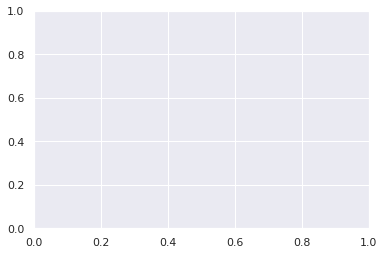

In [58]:
fig, ax = plt.subplots()
ax.bar(x=station_code, height=summary_occupation_exp_1.loc['50%', :])
ax.set_ylabel('Porcentaje de ocupación (%)')
ax.set_xlabel('')

In [29]:
for file in [2,3], [4,5]:
    print(file)

[2, 3]
[4, 5]


In [26]:
def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [27]:
res1 = np.random.normal(size=50)
res2 = np.random.normal(size=50)
mean_confidence_interval(res1 - res2)

(0.12735471512364896, -0.20198907394917678, 0.45669850419647473)

In [2]:
n_experiments = 2
n_replications = 2
n_executions = n_experiments * n_replications

statistics = (
    'totalUsers',
    'co2Avoided',
    'totalKm',
    'totalLostCustomers',
    'delayedUsers',
    'totalLostTime',
)

results = { f'{statistic}': [] for statistic in statistics }
stations_population_data = []

for exp in range(1, n_experiments + 1):
    for rep in range(1, n_replications + 1):
        file = open(f'../Modelo/MiBiciTuBici/model-output/output-exp{exp}-rep{rep}.json')
        data = json.load(file)
        stations_population_data.append(data['estaciones']) 

        for statistic in statistics:
            results[statistic].append(data[statistic]) 

In [7]:
results.keys()

dict_keys(['totalUsers', 'co2Avoided', 'totalKm', 'totalLostCustomers', 'delayedUsers', 'totalLostTime'])

In [13]:
len(stations_population_data)

4

tengo 4 ejecuciones, cada ejecución tiene datos de 72 estaciones

In [15]:
stations_population_data[1][0] # datos de la segunda ejecución, primera estación
stations_population_data[1][0]['bikesDeposited'] # datos de la segunda ejecución, primera estación

19

In [16]:
stations_population_data[1][0]['percentageOfOccupation'] # datos de la segunda ejecución, primera estación

{'plainDataTable': [[0.0, 5.0],
  [0.016666666666666666, 5.0],
  [0.03333333333333333, 5.0],
  [0.05, 5.0],
  [0.06666666666666667, 5.0],
  [0.08333333333333333, 5.0],
  [0.09999999999999999, 5.0],
  [0.11666666666666665, 5.0],
  [0.13333333333333333, 5.0],
  [0.15, 5.0],
  [0.16666666666666666, 5.0],
  [0.18333333333333332, 5.0],
  [0.19999999999999998, 5.0],
  [0.21666666666666665, 5.0],
  [0.2333333333333333, 5.0],
  [0.24999999999999997, 5.0],
  [0.26666666666666666, 5.0],
  [0.2833333333333333, 5.0],
  [0.3, 5.0],
  [0.31666666666666665, 5.0],
  [0.3333333333333333, 5.0],
  [0.35, 5.0],
  [0.36666666666666664, 5.0],
  [0.3833333333333333, 5.0],
  [0.39999999999999997, 5.0],
  [0.41666666666666663, 5.0],
  [0.4333333333333333, 5.0],
  [0.44999999999999996, 0.0],
  [0.4666666666666666, 0.0],
  [0.4833333333333333, 0.0],
  [0.49999999999999994, 0.0],
  [0.5166666666666666, 0.0],
  [0.5333333333333333, 0.0],
  [0.55, 0.0],
  [0.5666666666666668, 0.0],
  [0.5833333333333335, 0.0],
  [0

In [56]:
print('-> calculating confidence intervals...')
confidence_intervals = { f'{statistic}': None for statistic in statistics }
for statistic, values in results.items():
    mean, lower, upper = mean_confidence_interval(values)
    confidence_intervals[statistic] = (lower, mean, upper)
    
confidence_intervals = pd.DataFrame(confidence_intervals).T
confidence_intervals.columns = ('Cota inferior', 'Media', 'Cota superior')
confidence_intervals = confidence_intervals.round(decimals=2)
confidence_intervals.to_csv('../Modelo/MiBiciTuBici/processed-model-output/intervals.csv')

print('-> generating summary of results...')
pd.DataFrame(results).describe().T.to_csv('../Modelo/MiBiciTuBici/processed-model-output/stats.csv')

-> calculating confidence intervals...
-> generating summary of results...


In [5]:
n_stations = len(stations_population_data[0])
stations_results = [[] for _ in range(n_stations)]

for i in range(n_executions):
    for j in range(n_stations):
        stations_results[j].append(stations_population_data[i][j])

-> generating histograms for station 0
-> generating histograms for station 1
-> generating histograms for station 2
-> generating histograms for station 3
-> generating histograms for station 4
Done.


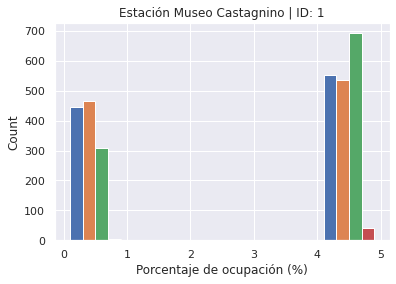

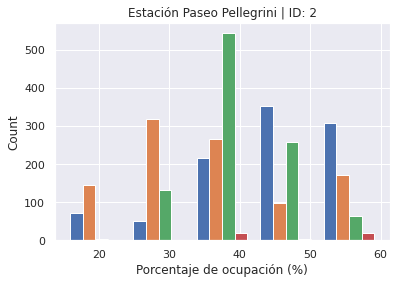

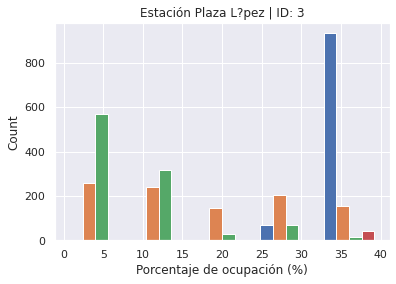

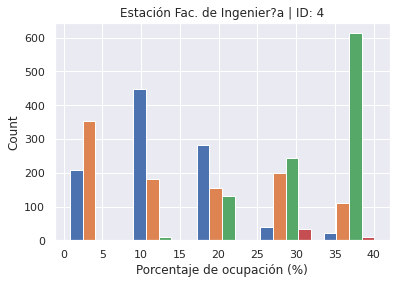

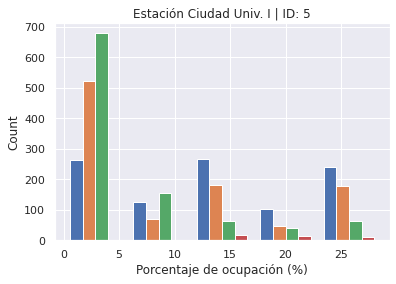

In [55]:
for station_id in range(5):
    print(f'-> generating histograms for station {station_id}')
    station_name = stations_results[station_id][0]['name']
    station_code = stations_results[station_id][0]['stationCode']
    occupied_percentage_along_runs = []
    
    for exec_id in range(n_executions):
         occupied_percentage_along_runs.append(
             np.array([xy[1] for xy in stations_results[station_id][exec_id]['percentageOfOccupation']['plainDataTable'][:-1]])
         )
            
    occupied_percentage_along_runs = np.array(occupied_percentage_along_runs, dtype=object).flatten()
    fig, ax = plt.subplots()
    ax.hist(occupied_percentage_along_runs, bins=5)
    ax.set_title(f"Estación {station_name} | ID: {station_code}")
    ax.set_xlabel('Porcentaje de ocupación (%)')
    ax.set_ylabel('Count')
    fig.savefig(f'../Modelo/MiBiciTuBici/processed-model-output/histogram-code{station_code}.pdf', dpi=100)
    
print('Done.')